In [94]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as ax
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
DATA_DIR = "./data/"
WEB = "https://www.worldometers.info/coronavirus/"

# COVID-19 expansion tracking and Mathematical Model.

### 0. Introduction and motivation

SARS-CoV-2 is a virus belonging to the coronaviruses family that was first detected in Hubei province, Mainland China, in December 2019 and triggered an ongoing global pandemia.
Because of the high $R_0$ (estimated between 2 and 3) and the asymptomatic nature of the incubation period, it's necessary to develop mathematical models for prediction, that will prevent further consecuencies by anticipating expansion rate.

### 1. Preliminary analysis

This section is intended to act like a toolbox providing access to resources and data management functions, visualization tools will also be provided.

In [32]:
columns = ["Country/Region","Confirmed","Deaths","Recovered"]

In [135]:
def timeEvolution(country):
    data_files = sorted(os.listdir(DATA_DIR))
    """
    Returns a pandas DataFrame with information of a country (Confirmed,Deaths,Recovered) by day
    since the beginig of the outbreak.
    
    params:
    
        -country (String): target country
    
    returns:
        -Pandas DataFrame if information is available , else None.
    """
    dic = []
    for file in data_files:
        key = file.split(".csv")[0]
        df = pd.read_csv(DATA_DIR + file)
        indexes = df["Country/Region"] == country #rows associated with country
        if any(indexes):
            country_data = df[df["Country/Region"] == country][columns].sum() #all records of that country
            dic.append([key]+list(country_data[columns[1:]]))
        else: #no rows
            dic.append([key,0,0,0])
    
    df = pd.DataFrame(dic)
    df.columns = ["Date"]+columns[1:]
    return df
        
def worldTimeEvolution(): #about 20s
    data_files = sorted(os.listdir(DATA_DIR))
    """
    Returns a dictionary indexed by country of DataFrames with information about countries since outbreak
    
    returns:
        -dictionatry of pandas DataFrames
    """
    dic = {}
    countries = pd.read_csv(DATA_DIR+data_files[-1])["Country/Region"].unique()
    for country in countries:
        dic[country] = timeEvolution(country)  
    return dic

In [140]:
"""
Ignore

def deleteUnnamed():
    data_files = sorted(os.listdir(DATA_DIR))
    for file in data_files:
        df = pd.read_csv(DATA_DIR + file)
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        df.to_csv(DATA_DIR+file, mode='w', header=True)
deleteUnnamed()
"""

In [98]:
def graphProgression(countryDF,param): #TODO: x axis problem with dates, too messy
    """
    Graphs the progression in time of a given parameter regarding country info
    
    params:
        -countryDF (pandas.DataFrame): info about the country (see timeEvolution or worldTimeEvolution)
        -param (String): "Confirmed" -> confirmed cases of COVID-19 in country
                         "Deaths" -> deaths by COVID-19 in country
                         "Recovered" -> recovered patients in country 

    """
   
    x = range(len(countryDF["Date"]))
    y = list(countryDF[param].astype(int))
    plt.plot(x,y)
    
    plt.yticks(range(0,max(y)+1,max(y)//10))
    plt.title("{} COVID-19".format(param))
    plt.ylabel(param)
    plt.xlabel("Days from outbreak")
    plt.show()

In [137]:
def realTimeEvolution():
    """
    Returns a Pandas DataFrame with infomration about the real time expansion of the virus.
    
    returns:
        -pandas Dataframe
    """
    cols = ["Country","Total Cases","New Cases","Total Deaths","New Deaths","Active Cases","Total Recovered","Critical"]
    page = requests.get(WEB)
    soup = BeautifulSoup(page.content, 'html.parser')
    countryTable = soup.find_all('tbody')[0]
    rows = countryTable.find_all("tr")
    data =[]
    for row in rows:
        info = row.find_all("td")
        
        data.append([data.text.strip().replace(",","") if data.text.strip() != "" else "0" for data in info])
    table = pd.DataFrame(data,columns=cols)
    #drop row 'Total:' as of now
    table.drop(table.tail(1).index, inplace=True)
    return table

def updateData():
    """
    Stores today's evolution data in csv format
    
    """
    df = realTimeEvolution()[["Country","Total Cases","Total Deaths","Total Recovered"]]
    df.columns=columns
    now = datetime.now()
    df.to_csv(DATA_DIR+now.strftime("%Y-%m-%d-%H-%M.csv"))

In [138]:
#local=pd.read_csv("data/2020-02-25-22-00.csv")
#local = local.loc[:, ~local.columns.str.contains('^Unnamed')]
#local
#updateData()

In [169]:
#import json
#from pprint import pprint
#import re

def getDemography(country):
    #TODO mine https://www.populationpyramid.net/<country>/2019/ , they have download by link, need to know country number, explore HTML + wget
    DEM = "https://www.populationpyramid.net/"+country+"/2019/"

    html_page = requests.get(DEM)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    #print(soup)
    page_data = soup.find(id="pp-csv-link")
    print(page_data)
    
    #page_data = json.loads(page_data)
def getInmigrationData(country):
    pass #no clue from where
country="France"
getDemography(country.lower())

<a href="" id="pp-csv-link">Excel CSV</a>


In [15]:
# For making real time source and dash-2019-new-coronavirus data repo
"""
country_info = worldTimeEvolution()
A  = set(realTimeEvolution()["Country"])
B = set(country_info.keys())
translate = {"Macau":"Macao","South Korea":"S. Korea","US":"USA","United Arab Emirates":"UAE","Mainland China":"China","State of Palestine":"Palestine"}
for file in data_files:
    df = pd.read_csv(DATA_DIR+file)
    for country in translate:
        df["Country/Region"].replace(country,translate[country],inplace=True)
    df.to_csv(DATA_DIR+file)


days = {}
for file in data_files:
    sp = file.split(".")[0].split("-")
    day = "-".join(sp[:3])
    if day not in days:
        days[day]=[file]
    else:
        days[day]+=[file]
lasts = [sorted(l,reverse=True)[0] for l in days.values()]

for file in data_files:
    if file not in lasts:
        os.system("rm "+DATA_DIR+file)
    
"""

'\ncountry_info = worldTimeEvolution()\nA  = set(realTimeEvolution()["Country"])\nB = set(country_info.keys())\ntranslate = {"Macau":"Macao","South Korea":"S. Korea","US":"USA","United Arab Emirates":"UAE","Mainland China":"China","State of Palestine":"Palestine"}\nfor file in data_files:\n    df = pd.read_csv(DATA_DIR+file)\n    for country in translate:\n        df["Country/Region"].replace(country,translate[country],inplace=True)\n    df.to_csv(DATA_DIR+file)\n\n\ndays = {}\nfor file in data_files:\n    sp = file.split(".")[0].split("-")\n    day = "-".join(sp[:3])\n    if day not in days:\n        days[day]=[file]\n    else:\n        days[day]+=[file]\nlasts = [sorted(l,reverse=True)[0] for l in days.values()]\n\nfor file in data_files:\n    if file not in lasts:\n        os.system("rm "+DATA_DIR+file)\n    \n'

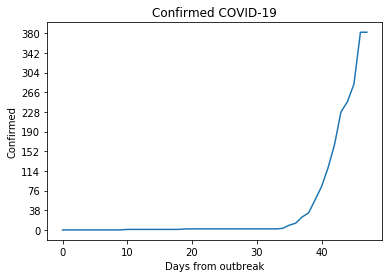

In [131]:
graphProgression(timeEvolution("Spain"),"Confirmed")